# Notebook 08: Anomaly Detection (Bonus)

## Mục Tiêu
- Phát hiện traffic anomalies (spikes, drops)
- Phân biệt DDoS patterns
- Kết hợp với autoscaling policy

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings

warnings.filterwarnings('ignore')

# Thêm src vào path
sys.path.insert(0, os.path.abspath('..'))

from src.data.preprocessor import load_timeseries
from src.anomaly.detector import AnomalyDetector

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [2]:
# Load time series
df = load_timeseries('../data/processed/timeseries_15min.parquet')

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns: {df.columns.tolist()}")

Data shape: (5952, 11)
Date range: 1995-07-01 00:00:00 to 1995-08-31 23:45:00

Columns: ['request_count', 'bytes_total', 'bytes_mean', 'bytes_std', 'success_count', 'error_count', 'server_error_count', 'unique_hosts', 'error_rate', 'avg_request_size', 'is_storm_period']


In [3]:
# Use request_count as main metric
traffic = df['request_count'].copy()

print(f"Traffic statistics:")
print(traffic.describe())

Traffic statistics:
count    5952.000000
mean      581.585181
std       408.094643
min         0.000000
25%       300.000000
50%       497.000000
75%       817.250000
max      4212.000000
Name: request_count, dtype: float64


## 2. Initialize Anomaly Detector

In [4]:
# Create detector
detector = AnomalyDetector()

print("Anomaly Detector initialized")
print("Available methods:")
print("  - Z-score: Statistical deviation detection")
print("  - IQR: Interquartile range based detection")
print("  - Isolation Forest: ML-based outlier detection")
print("  - Rolling: Comparison with rolling statistics")

Anomaly Detector initialized
Available methods:
  - Z-score: Statistical deviation detection
  - IQR: Interquartile range based detection
  - Isolation Forest: ML-based outlier detection
  - Rolling: Comparison with rolling statistics


## 3. Z-Score Based Detection

In [5]:
# Z-score detection
zscore_anomalies = detector.detect_zscore(traffic, threshold=3.0)

print(f"Z-Score Anomalies (threshold=3.0):")
print(f"  Total anomalies: {zscore_anomalies.sum()}")
print(f"  Percentage: {zscore_anomalies.sum()/len(traffic)*100:.2f}%")

Z-Score Anomalies (threshold=3.0):
  Total anomalies: 46
  Percentage: 0.77%


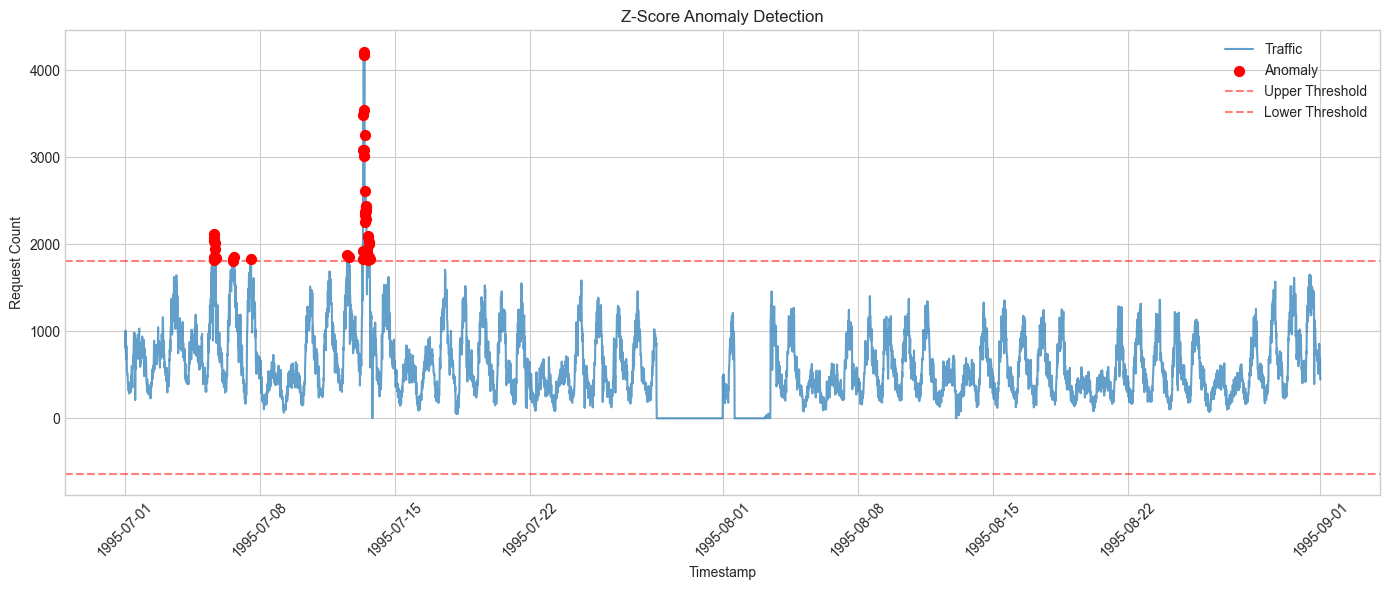

In [6]:
# Visualize Z-score anomalies
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(traffic.index, traffic.values, label='Traffic', alpha=0.7)
ax.scatter(traffic.index[zscore_anomalies], traffic[zscore_anomalies], 
           color='red', s=50, label='Anomaly', zorder=5)

# Add thresholds
mean = traffic.mean()
std = traffic.std()
ax.axhline(y=mean + 3*std, color='red', linestyle='--', alpha=0.5, label='Upper Threshold')
ax.axhline(y=mean - 3*std, color='red', linestyle='--', alpha=0.5, label='Lower Threshold')

ax.set_xlabel('Timestamp')
ax.set_ylabel('Request Count')
ax.set_title('Z-Score Anomaly Detection')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/anomaly_zscore.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. IQR Based Detection

In [7]:
# IQR detection
iqr_anomalies = detector.detect_iqr(traffic, k=1.5)

print(f"IQR Anomalies (k=1.5):")
print(f"  Total anomalies: {iqr_anomalies.sum()}")
print(f"  Percentage: {iqr_anomalies.sum()/len(traffic)*100:.2f}%")

IQR Anomalies (k=1.5):
  Total anomalies: 98
  Percentage: 1.65%


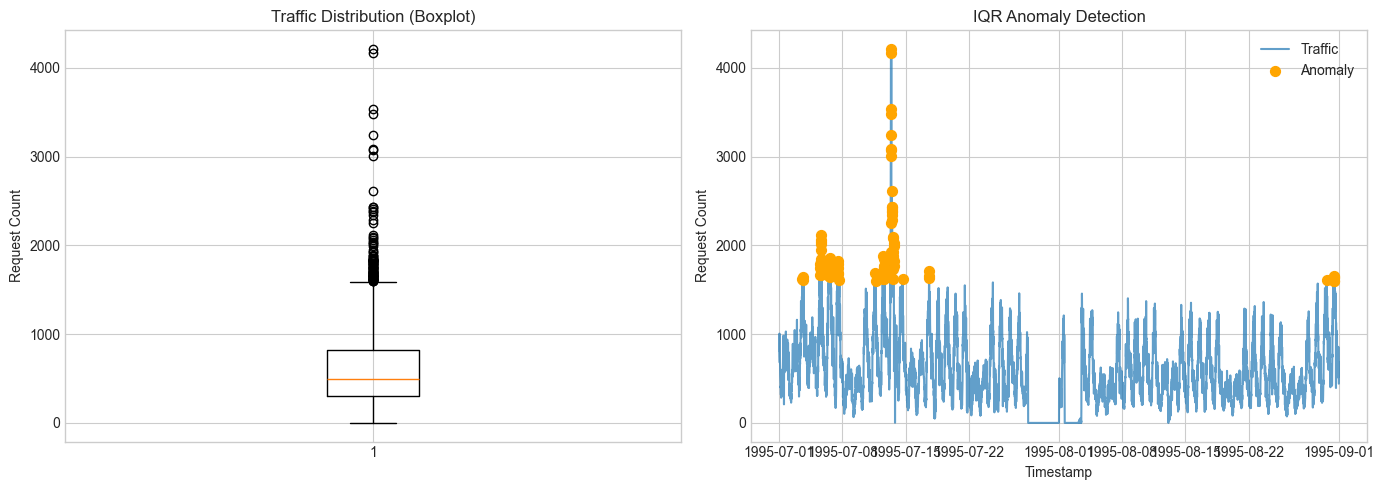

In [8]:
# Visualize with boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
axes[0].boxplot(traffic.dropna())
axes[0].set_title('Traffic Distribution (Boxplot)')
axes[0].set_ylabel('Request Count')

# Time series with IQR anomalies
axes[1].plot(traffic.index, traffic.values, label='Traffic', alpha=0.7)
axes[1].scatter(traffic.index[iqr_anomalies], traffic[iqr_anomalies], 
                color='orange', s=50, label='Anomaly', zorder=5)
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('Request Count')
axes[1].set_title('IQR Anomaly Detection')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/anomaly_iqr.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Rolling Window Detection

In [9]:
# Rolling window detection (compare with local statistics)
rolling_anomalies = detector.detect_rolling(traffic, window=96, threshold=2.5)  # 24-hour window

print(f"Rolling Window Anomalies:")
print(f"  Total anomalies: {rolling_anomalies.sum()}")
print(f"  Percentage: {rolling_anomalies.sum()/len(traffic)*100:.2f}%")

Rolling Window Anomalies:
  Total anomalies: 163
  Percentage: 2.74%


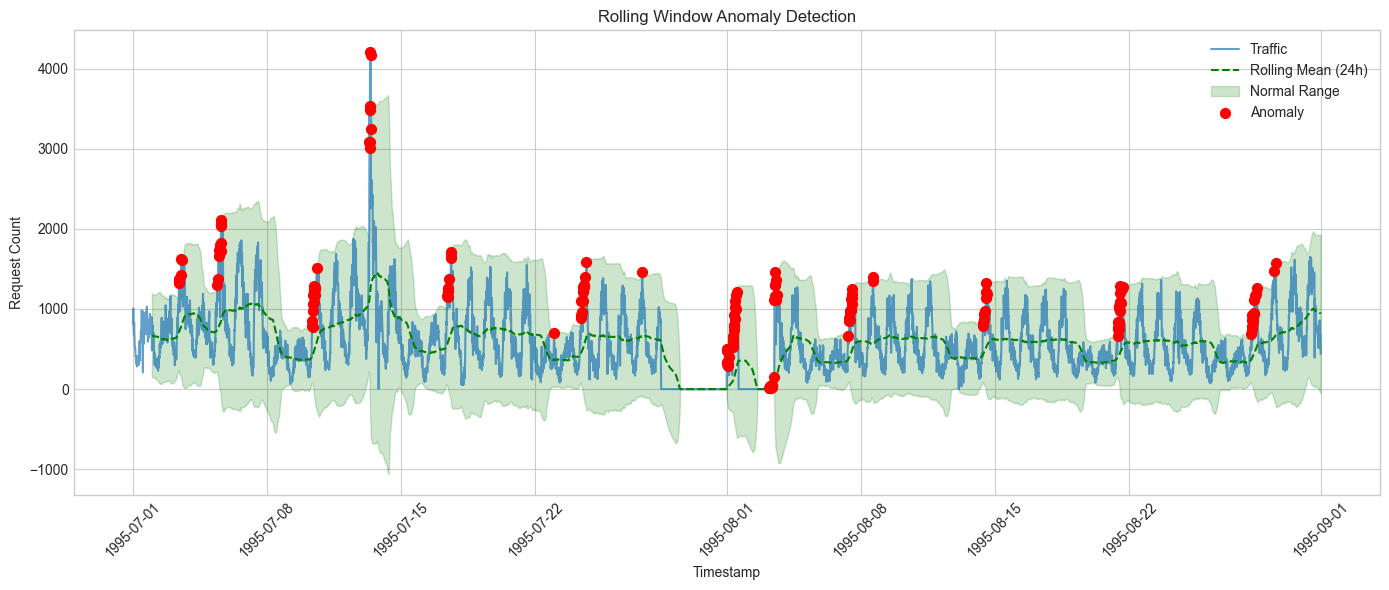

In [10]:
# Visualize rolling detection
fig, ax = plt.subplots(figsize=(14, 6))

# Calculate rolling stats for visualization
rolling_mean = traffic.rolling(96).mean()
rolling_std = traffic.rolling(96).std()

ax.plot(traffic.index, traffic.values, label='Traffic', alpha=0.7)
ax.plot(rolling_mean.index, rolling_mean.values, label='Rolling Mean (24h)', 
        color='green', linestyle='--')
ax.fill_between(rolling_mean.index, 
                rolling_mean - 2.5*rolling_std, 
                rolling_mean + 2.5*rolling_std,
                alpha=0.2, color='green', label='Normal Range')

ax.scatter(traffic.index[rolling_anomalies], traffic[rolling_anomalies], 
           color='red', s=50, label='Anomaly', zorder=5)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Request Count')
ax.set_title('Rolling Window Anomaly Detection')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/anomaly_rolling.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Isolation Forest Detection

In [11]:
# Isolation Forest (ML-based)
# Create features for isolation forest
from sklearn.ensemble import IsolationForest

# Create feature matrix
features = pd.DataFrame({
    'request_count': traffic,
    'hour': traffic.index.hour,
    'day_of_week': traffic.index.dayofweek,
    'lag_1': traffic.shift(1),
    'lag_4': traffic.shift(4),  # 1-hour lag
    'rolling_mean_4': traffic.rolling(4).mean(),
    'diff': traffic.diff()
}).dropna()

# Train Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,  # Expect 5% anomalies
    random_state=42,
    n_estimators=100
)

iso_predictions = iso_forest.fit_predict(features)
iso_anomalies = pd.Series(iso_predictions == -1, index=features.index)

print(f"Isolation Forest Anomalies:")
print(f"  Total anomalies: {iso_anomalies.sum()}")
print(f"  Percentage: {iso_anomalies.sum()/len(features)*100:.2f}%")

Isolation Forest Anomalies:
  Total anomalies: 298
  Percentage: 5.01%


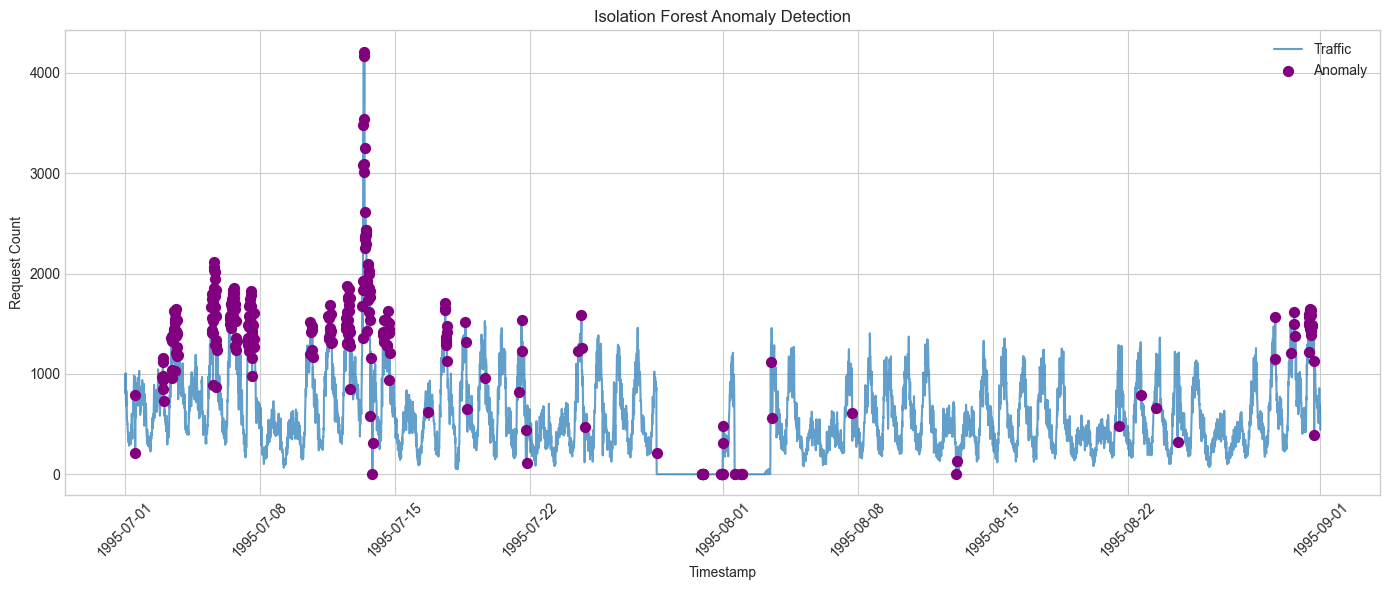

In [12]:
# Visualize Isolation Forest results
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(traffic.index, traffic.values, label='Traffic', alpha=0.7)
ax.scatter(features.index[iso_anomalies], traffic.loc[features.index[iso_anomalies]], 
           color='purple', s=50, label='Anomaly', zorder=5)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Request Count')
ax.set_title('Isolation Forest Anomaly Detection')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/anomaly_isolation_forest.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Spike Detection

In [13]:
# Detect sudden spikes
spikes = detector.detect_spikes(traffic, window=4, threshold=2.0)

print(f"Spike Detection:")
print(f"  Total spikes: {spikes.sum()}")
print(f"  Percentage: {spikes.sum()/len(traffic)*100:.2f}%")

Spike Detection:
  Total spikes: 18
  Percentage: 0.30%


In [14]:
# Analyze spike patterns
spike_times = traffic.index[spikes]
spike_values = traffic[spikes]

print("\nTop 10 Largest Spikes:")
top_spikes = spike_values.nlargest(10)
for timestamp, value in top_spikes.items():
    print(f"  {timestamp}: {value:.0f} requests")


Top 10 Largest Spikes:
  1995-08-03 11:30:00: 1115 requests
  1995-08-24 14:15:00: 899 requests
  1995-08-01 00:00:00: 481 requests
  1995-08-07 07:15:00: 481 requests
  1995-08-04 06:00:00: 442 requests
  1995-08-09 06:30:00: 403 requests
  1995-08-19 07:45:00: 390 requests
  1995-07-18 07:00:00: 269 requests
  1995-07-08 05:00:00: 267 requests
  1995-08-26 07:30:00: 219 requests


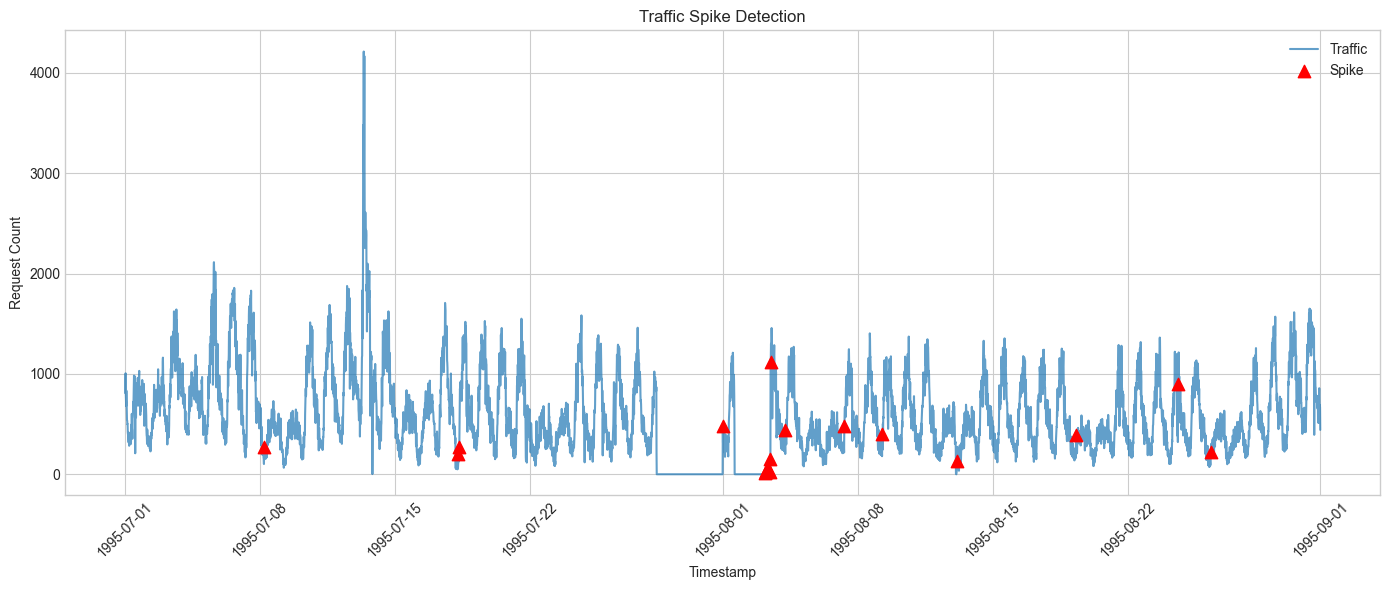

In [15]:
# Visualize spikes
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(traffic.index, traffic.values, label='Traffic', alpha=0.7)
ax.scatter(traffic.index[spikes], traffic[spikes], 
           color='red', s=80, marker='^', label='Spike', zorder=5)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Request Count')
ax.set_title('Traffic Spike Detection')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/anomaly_spikes.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. DDoS-like Pattern Detection

In [16]:
# DDoS pattern: High traffic + Low unique hosts ratio
# (Many requests from few sources)

if 'unique_hosts' in df.columns:
    ddos_suspicious = detector.detect_ddos_pattern(
        traffic, 
        df['unique_hosts'],
        traffic_threshold=2.0,
        host_ratio_threshold=0.5
    )
    
    print(f"DDoS-like Pattern Detection:")
    print(f"  Suspicious events: {ddos_suspicious.sum()}")
    print(f"  Percentage: {ddos_suspicious.sum()/len(traffic)*100:.2f}%")
else:
    print("unique_hosts column not available for DDoS analysis")
    ddos_suspicious = pd.Series(False, index=traffic.index)

DDoS-like Pattern Detection:
  Suspicious events: 209
  Percentage: 3.51%


## 9. Storm Period Analysis

In [17]:
# Analyze the storm period (server outage)
storm_mask = df['is_storm_period'] == 1
storm_periods = df[storm_mask]

print(f"Storm Period Analysis:")
print(f"  Storm records: {len(storm_periods)}")
print(f"  Start: {storm_periods.index.min() if len(storm_periods) > 0 else 'N/A'}")
print(f"  End: {storm_periods.index.max() if len(storm_periods) > 0 else 'N/A'}")

Storm Period Analysis:
  Storm records: 151
  Start: 1995-08-01 15:00:00
  End: 1995-08-03 04:30:00


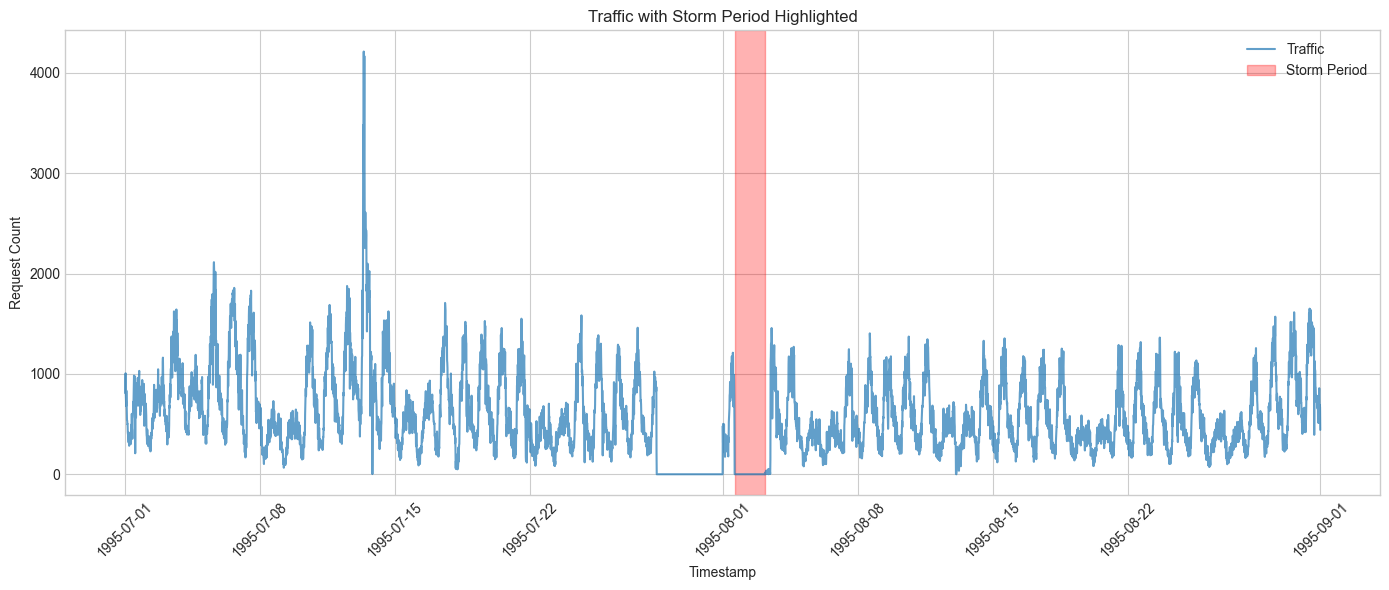

In [18]:
# Visualize storm period
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(traffic.index, traffic.values, label='Traffic', alpha=0.7)

# Highlight storm period
if len(storm_periods) > 0:
    storm_start = storm_periods.index.min()
    storm_end = storm_periods.index.max()
    ax.axvspan(storm_start, storm_end, alpha=0.3, color='red', label='Storm Period')

ax.set_xlabel('Timestamp')
ax.set_ylabel('Request Count')
ax.set_title('Traffic with Storm Period Highlighted')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/anomaly_storm.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Combined Anomaly Score

In [19]:
# Combine multiple detection methods
combined_score = detector.get_combined_anomaly_score(
    traffic,
    methods=['zscore', 'iqr', 'rolling', 'spike']
)

print(f"Combined Anomaly Score Distribution:")
print(combined_score.describe())

Combined Anomaly Score Distribution:
count    5952.000000
mean        0.061828
std         0.281403
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
dtype: float64


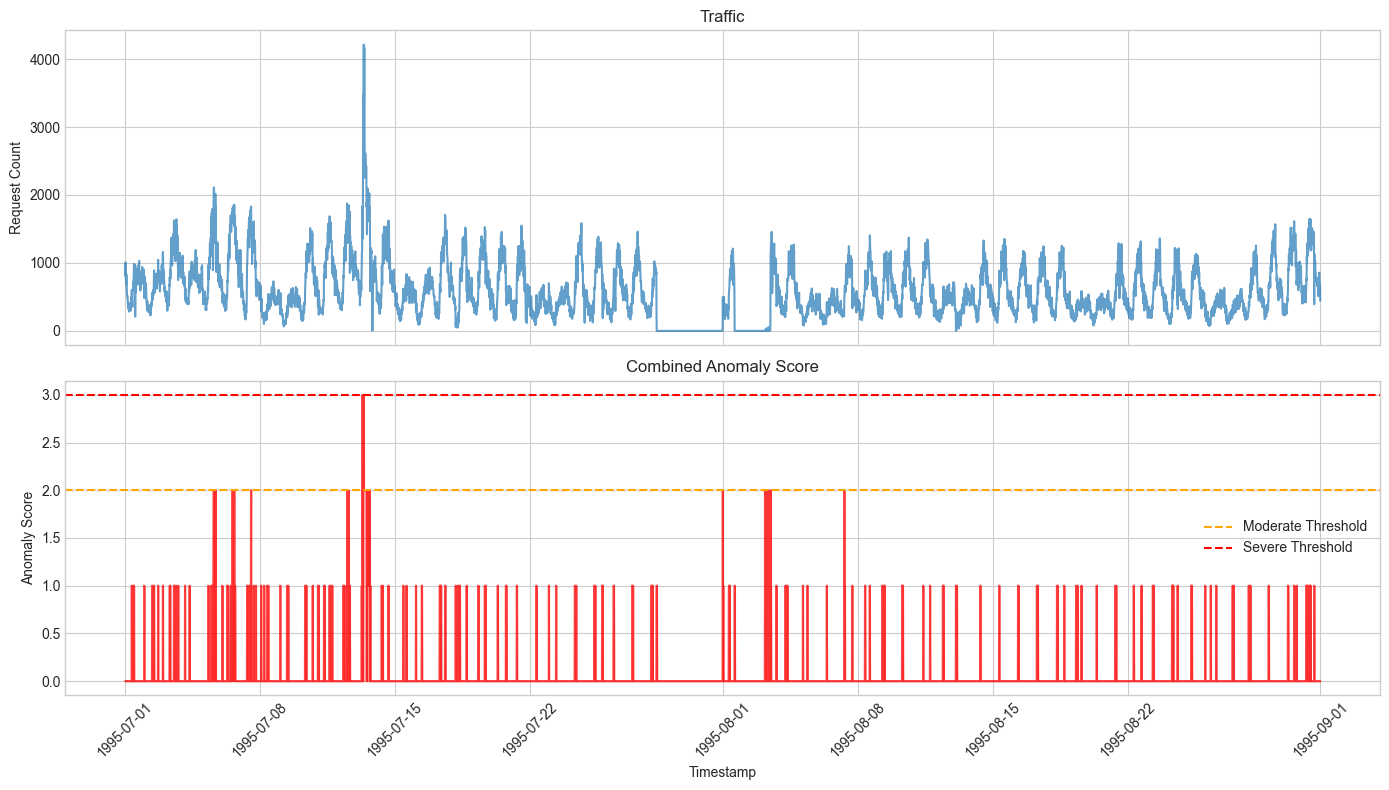

In [20]:
# Visualize combined score
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Traffic
axes[0].plot(traffic.index, traffic.values, alpha=0.7)
axes[0].set_ylabel('Request Count')
axes[0].set_title('Traffic')

# Combined anomaly score
axes[1].plot(combined_score.index, combined_score.values, color='red', alpha=0.7)
axes[1].axhline(y=2, color='orange', linestyle='--', label='Moderate Threshold')
axes[1].axhline(y=3, color='red', linestyle='--', label='Severe Threshold')
axes[1].fill_between(combined_score.index, 0, combined_score.values, alpha=0.3, color='red')
axes[1].set_ylabel('Anomaly Score')
axes[1].set_xlabel('Timestamp')
axes[1].set_title('Combined Anomaly Score')
axes[1].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/anomaly_combined_score.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Anomaly Report

In [21]:
# Generate anomaly report
report = detector.generate_report(traffic)
print(report)


                ANOMALY DETECTION REPORT

DATA SUMMARY:
  Total Records: 5,952
  Date Range: 1995-07-01 00:00:00 to 1995-08-31 23:45:00
  Mean: 581.59
  Std: 408.09
  Min: 0.00
  Max: 4212.00

DETECTION RESULTS:
------------------------------------------------------------

  Z-Score:
    - Anomalies: 46
    - Rate: 0.77%

  IQR:
    - Anomalies: 98
    - Rate: 1.65%

  Rolling Window:
    - Anomalies: 206
    - Rate: 3.46%

  Spike Detection:
    - Anomalies: 18
    - Rate: 0.30%

  DDoS Pattern:
    - Anomalies: 209
    - Rate: 3.51%

------------------------------------------------------------
SEVERE ANOMALIES (score >= 3):
  Count: 4
  Timestamps:
    - 1995-07-13 07:30:00: score=3, value=1835
    - 1995-07-13 08:15:00: score=3, value=3078
    - 1995-07-13 08:30:00: score=3, value=3480
    - 1995-07-13 09:00:00: score=3, value=4212




## 12. Summary

In [22]:
print("="*70)
print("               ANOMALY DETECTION SUMMARY")
print("="*70)
print(f"\nData Period: {traffic.index.min()} to {traffic.index.max()}")
print(f"Total Records: {len(traffic)}")
print(f"\n" + "-"*70)
print("DETECTION RESULTS:")
print("-"*70)
print(f"{'Method':<25} {'Anomalies':<15} {'Percentage':<15}")
print("-"*70)
print(f"{'Z-Score (3σ)':<25} {zscore_anomalies.sum():<15} {zscore_anomalies.sum()/len(traffic)*100:.2f}%")
print(f"{'IQR (1.5x)':<25} {iqr_anomalies.sum():<15} {iqr_anomalies.sum()/len(traffic)*100:.2f}%")
print(f"{'Rolling Window':<25} {rolling_anomalies.sum():<15} {rolling_anomalies.sum()/len(traffic)*100:.2f}%")
print(f"{'Isolation Forest':<25} {iso_anomalies.sum():<15} {iso_anomalies.sum()/len(features)*100:.2f}%")
print(f"{'Spike Detection':<25} {spikes.sum():<15} {spikes.sum()/len(traffic)*100:.2f}%")
print("-"*70)
print(f"\nKEY FINDINGS:")
print(f"  - Storm period detected: {storm_mask.sum()} records")
print(f"  - Major traffic spikes: {spikes.sum()}")
severe_anomalies = (combined_score >= 3).sum()
print(f"  - Severe anomalies (score >= 3): {severe_anomalies}")
print(f"\nRECOMMENDATIONS:")
print(f"  - Use combined anomaly score for autoscaling decisions")
print(f"  - Set alerts for score > 3 (severe anomalies)")
print(f"  - Investigate DDoS patterns during high-traffic spikes")
print("="*70)

               ANOMALY DETECTION SUMMARY

Data Period: 1995-07-01 00:00:00 to 1995-08-31 23:45:00
Total Records: 5952

----------------------------------------------------------------------
DETECTION RESULTS:
----------------------------------------------------------------------
Method                    Anomalies       Percentage     
----------------------------------------------------------------------
Z-Score (3σ)              46              0.77%
IQR (1.5x)                98              1.65%
Rolling Window            163             2.74%
Isolation Forest          298             5.01%
Spike Detection           18              0.30%
----------------------------------------------------------------------

KEY FINDINGS:
  - Storm period detected: 151 records
  - Major traffic spikes: 18
  - Severe anomalies (score >= 3): 4

RECOMMENDATIONS:
  - Use combined anomaly score for autoscaling decisions
  - Set alerts for score > 3 (severe anomalies)
  - Investigate DDoS patterns during 